In [1]:
import torch as t
import pandas as pd
# import numpy as np
# from tqdm import tqdm


from src.preprocess import *
from src.models import *
from src.utils import *

from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.simplefilter('ignore')


In [2]:
# setting up
DEVICE = 'cuda' if t.cuda.is_available() else 'cpu'
DEVICE = 'mps' if t.backends.mps.is_available() else DEVICE
DATASET_PATH = './dataset/result.csv'
LOOK_FWD = 700
W_SIZE = 400
THR = 0.000001
TRAIN_TEST_R = 0.8
TRAIN_VAL_R = 0.8
HIDDEN = 40
N_LAYERS = 5
BATCH_SIZE = 256
SAMPLES = 4000000

In [3]:
import pickle

unzip_dataset('./dataset/')
pckl_name = './dataset/dataset.pckl'
if os.path.isfile(pckl_name):
    print('loading the dataset...')
    with open(pckl_name, 'rb') as f:
        dataset_ = pickle.load(f)
else: 
    dataset_ = pd.read_csv(DATASET_PATH, index_col=0)
    print('saving the dataset...')
    with open(pckl_name, 'wb+') as f:
        pickle.dump(dataset, f)

dataset = dataset_[:SAMPLES]
dataset.shape

Dataset already extracted
loading the dataset...


(4000000, 79)

In [4]:
labels_name = './dataset/labels.pckl'
if os.path.isfile(labels_name):
    with open('./dataset/labels.pckl', 'rb') as f:
        labels = pickle.load(f)
else:
    labels = generate_labels(dataset_, LOOK_FWD, THR)
    with open('./dataset/labels.pckl', 'wb+') as f:
        pickle.dump(labels, f)
        
labels = labels[LOOK_FWD:dataset.shape[0]]
dataset_ = None
labels.shape

(3999300,)

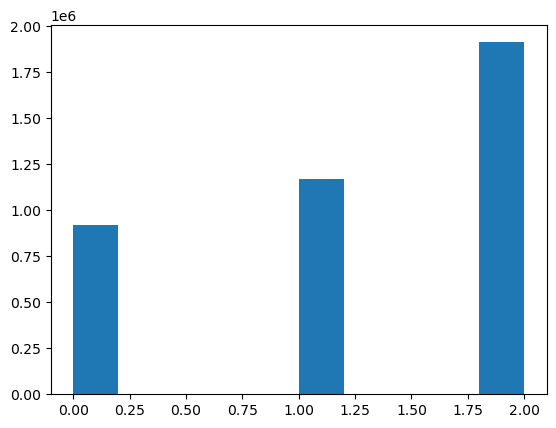

In [5]:
import matplotlib.pyplot as plt
plt.hist(labels)
plt.show()

In [6]:
labels.shape

(3999300,)

In [7]:
pipe = Pipe(W_SIZE)

train_index = int((dataset.shape[0] - LOOK_FWD * 2 - W_SIZE) * TRAIN_TEST_R)
test_index_start = train_index + W_SIZE
ds_train = dataset[:train_index]
ds_test = dataset[test_index_start: - LOOK_FWD * 2]

dataset = None

pipe.fit(ds_train)

train_t = pipe.transform(ds_train)
test_t = pipe.transform(ds_test)

train_l_t = t.tensor(labels[:train_t.shape[0]])
test_l_t = t.tensor(labels[test_index_start:test_index_start + test_t.shape[0]])

train_val_idx = int(train_l_t.shape[0] * TRAIN_VAL_R)

train_ds = t.utils.data.TensorDataset(train_t[:train_val_idx], train_l_t[:train_val_idx])
val_ds = t.utils.data.TensorDataset(train_t[train_val_idx:], train_l_t[train_val_idx:])
test_ds = t.utils.data.TensorDataset(test_t, test_l_t)

train_dl = t.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = t.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl = t.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE)

In [8]:
model = Att_GRU(train_t.shape[2], 5, 20, W_SIZE, DEVICE).to(device=DEVICE)
model(train_t[500:505].to(device=DEVICE)).shape

torch.Size([5, 3])

In [9]:
%%time
model_1 = Att_GRU(test_t.shape[2],
                  n_layers=N_LAYERS,
                  hidden=HIDDEN,
                  device=DEVICE,
                  window=W_SIZE).to(device=DEVICE)
optimizer = t.optim.Adam(model.parameters(), lr=1e-5)
lf = t.nn.CrossEntropyLoss()
sm = SummaryWriter('./runs')

train(train_dl, val_dl, model, optimizer, lf, 30, device=DEVICE, sm=sm)

train_loss: -1.000, train_acc_pre_rec: -1.000, -1.000, -1.000; || eval_loss: -1.000, eval_acc_pre_rec -1.000, -1.000, -1.000; || local_loss: 1.125:   0%|          | 0/30 [00:36<?, ?it/s]

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
t.save(model,'./models/train_gru_att_' + timestamp)